Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 2.2) 비트코인 시세 예측하기

### 바로가기

- [1. 시간정보가 포함된 데이터 살펴보기](#1.-시간정보가-포함된-데이터-살펴보기)
    - [market price 데이터셋의 기본 정보]
    - [시계열 데이터 살펴보기]
- [2. 파이썬 라이브러리를 활용한 시세 예측](#2.-파이썬-라이브러리를-활용한-시세-예측)
    - [ARIMA 모델 활용하기]
    - [Facebook Prophet 활용하기]
- [3. 더 나은 결과를 위한 방법들](#3.-더-나은-결과를-위한-방법들)
    - [상한가와 하한가 선정]
    - [이상치 제거하기]
    - [하이퍼 파라미터 선정하기]
- [재미로 알아보는 내일의 비트코인 시세](#재미로-알아보는-내일의-비트코인-시세)
- [부록 : 선배의 Summary](#부록-:-선배의-Summary)

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 1. 시간정보가 포함된 데이터 살펴보기

### [market price 데이터셋의 기본 정보]

In [2]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days

url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price.csv'
bitcoin_df = pd.read_csv(url, names = ['day', 'price'])

In [3]:
print(bitcoin_df.shape)
print(bitcoin_df.info())

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
day      365 non-null object
price    365 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [4]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


-----

### [시계열 데이터 살펴보기]

In [5]:
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [6]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


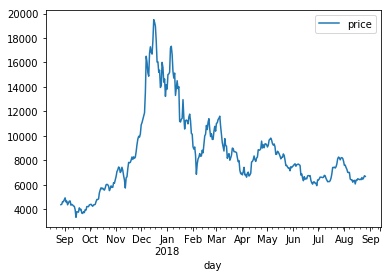

In [7]:
bitcoin_df.plot()
plt.show()

-----

# 2. 파이썬 라이브러리를 활용한 시세 예측

### [ARIMA 모델 활용하기]

###### 적절한 파라미터 선정하기
- ACF(Autocorrelation function), PACF(Partial autocorrelation function) 그래프를 통해 대략적인 파라미터를 선정합니다.

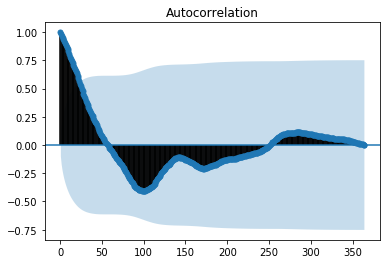

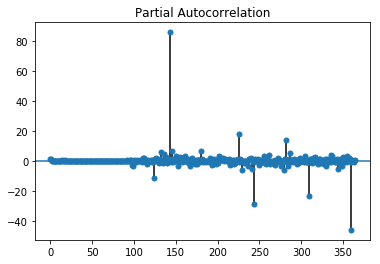

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()

-----

###### ARIMA 모델 학습
- 그래프를 토대로 1차 학습

In [16]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(bitcoin_df.price.values, order=(15,1,2))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                ARIMA(15, 1, 2)   Log Likelihood               -2756.430
Method:                       css-mle   S.D. of innovations            469.127
Date:                Sun, 13 Jan 2019   AIC                           5550.861
Time:                        15:56:14   BIC                           5624.906
Sample:                             1   HQIC                          5580.290
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7431     29.945      0.225      0.822     -51.948      65.434
ar.L1.D.y     -1.1768      0.081    -14.537      0.000      -1.335      -1.018
ar.L2.D.y     -0.7505      0.106     -7.079      0.0

-----

- 1차 결과를 토대로 2차 학습

In [21]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.074
Method:                       css-mle   S.D. of innovations            501.536
Date:                Sun, 13 Jan 2019   AIC                           5572.148
Time:                        15:57:09   BIC                           5595.531
Sample:                             1   HQIC                          5581.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3813     26.944      0.237      0.813     -46.428      59.191
ar.L1.D.y      0.4496      0.029     15.512      0.000       0.393       0.506
ar.L2.D.y     -0.9622      0.023    -42.313      0.0

-----

###### 모델의 성능 & 예측 결과 시각화
- 학습한 모델이 훈련 데이터에 대해서 예측한 결과만을 시각화합니다.

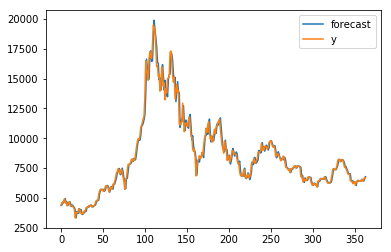

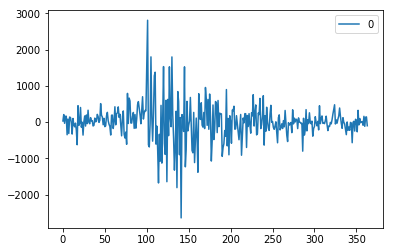

In [27]:
fig = model_fit.plot_predict() # 훈련 데이터에 대한 예측 결과
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동 시각화
residuals.plot()

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price-test.csv' 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [23]:
forecast_data = model_fit.forecast(steps=5) # 훈련 셋으로부터 5일 뒤를 예측

url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(url, names = ['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터 (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터 (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

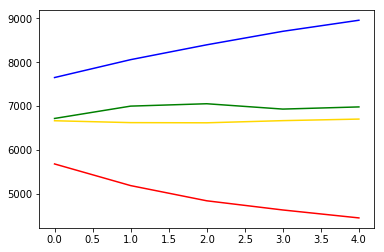

In [24]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

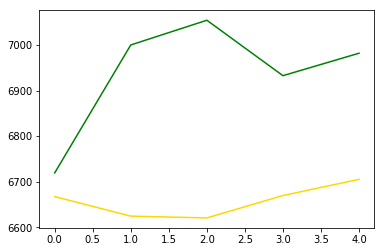

In [25]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

-----

### [Facebook Prophet 활용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 터미널(cmd)에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `conda install -c conda-forge fbprophet`
- prophet의 input data columns는 'ds'와 'y'로 고정되어야 합니다.
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미합니다. 비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋습니다.
- changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측합니다. 수치가 높을수록 overfitting에 가까워집니다.

###### Prophet 모델 학습

In [164]:
from fbprophet import Prophet

In [170]:
bitcoin_df = pd.read_csv(url, names = ['ds', 'y']) # prophet의 input data columns : 'ds', 'y'
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

-----

###### 모델로부터 예측할 기간을 정의하고, 결과를 도출.

In [171]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [172]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,755.707142,6218.050397,7553.567960,755.707142,755.707142,9.243126,9.243126,9.243126,8.089303,...,-0.007564,-0.007564,-0.007564,-1.146259,-1.146259,-1.146259,0.0,0.0,0.0,6868.850910
366,2018-08-28,759.578064,6275.258930,7549.769015,759.578064,759.578064,9.243126,9.243126,9.243126,8.153899,...,0.019411,0.019411,0.019411,-1.108638,-1.108638,-1.108638,0.0,0.0,0.0,6953.100528
367,2018-08-29,763.448985,6216.809570,7617.777497,761.648811,763.448985,9.243126,9.243126,9.243126,8.110622,...,-0.046261,-0.046261,-0.046261,-1.086243,-1.086243,-1.086243,0.0,0.0,0.0,6955.494928
368,2018-08-30,767.319907,6250.288429,7754.260110,753.295033,768.007924,9.243126,9.243126,9.243126,8.143508,...,-0.017927,-0.017927,-0.017927,-1.081690,-1.081690,-1.081690,0.0,0.0,0.0,7015.995983
369,2018-08-31,771.190829,6249.690452,7867.614720,745.251714,778.399233,9.243126,9.243126,9.243126,8.182008,...,0.035913,0.035913,0.035913,-1.097031,-1.097031,-1.097031,0.0,0.0,0.0,7081.080511


In [173]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6868.850910,6218.050397,7553.567960
366,2018-08-28,6953.100528,6275.258930,7549.769015
367,2018-08-29,6955.494928,6216.809570,7617.777497
368,2018-08-30,7015.995983,6250.288429,7754.260110
369,2018-08-31,7081.080511,6249.690452,7867.614720


-----

###### 결과의 시각화

- 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화합니다.

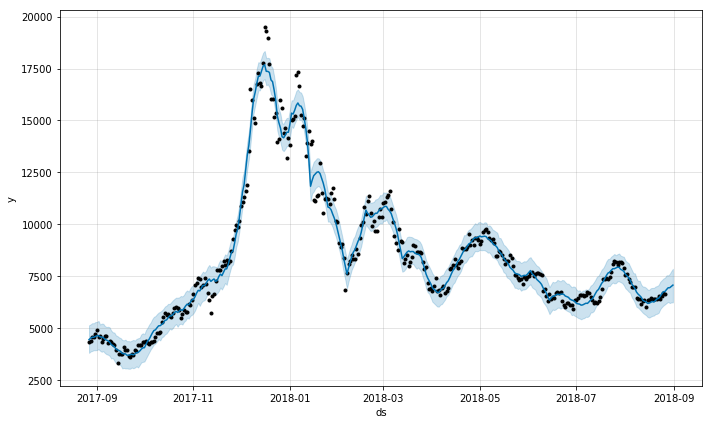

In [174]:
fig1 = prophet.plot(forecast_data)

-----

- seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화합니다.

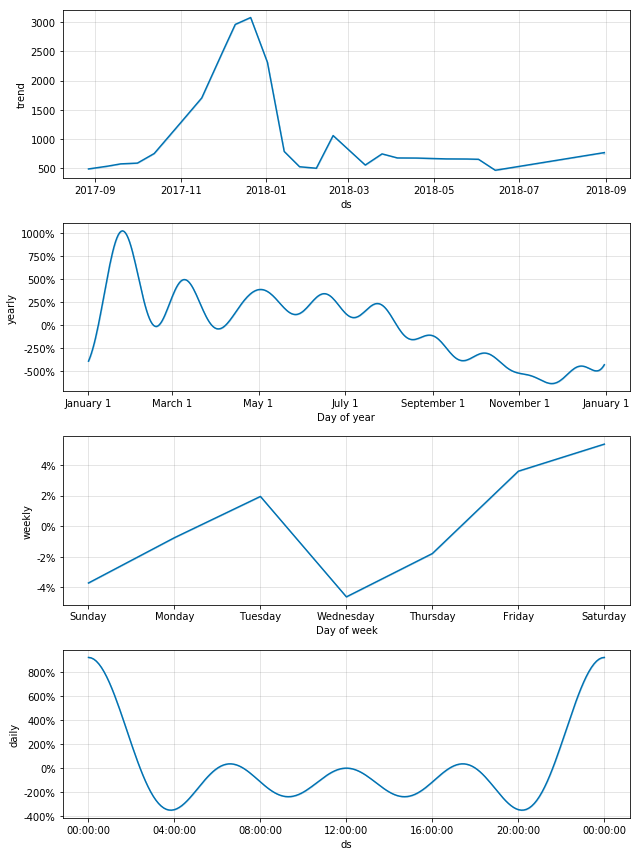

In [175]:
fig2 = prophet.plot_components(forecast_data)

-----

###### 모델의 성능
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산합니다.

In [176]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터

In [177]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

521.4617527207555
0.97386175731469


-----

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price-test.csv' 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [180]:
url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(url, names = ['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터 (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터 (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값

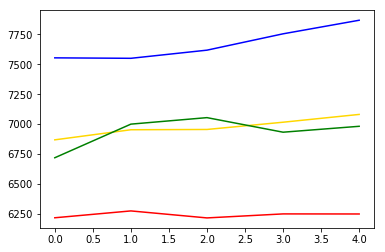

In [186]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

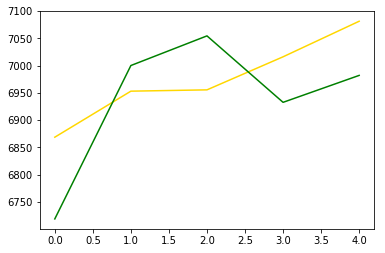

In [187]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

-----

# 3. 더 나은 결과를 위한 방법들

### [상한가와 하한가 선정]

-----

### [이상치 제거하기]

-----

### [하이퍼 파라미터 선정하기]

-----

# 재미로 알아보는 내일의 비트코인 시세

-----

# 부록 : 선배의 Summary